<h1 align="center", style="color:red"> Stock Price Prediction </h1>

# **I- Importing necessary libraries**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import xgboost as xgb
import lightgbm as lgb
import plotly.express as px
import plotly.graph_objects as go

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, IsolationForest, StackingRegressor
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor, XGBClassifier, plot_importance
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVC
from sklearn.multioutput import RegressorChain
from ydata_profiling import ProfileReport
from sklearn.decomposition import PCA
from scipy import stats
from scipy.stats import yeojohnson
from collections import Counter
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, RobustScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_regression, chi2, mutual_info_regression, RFE, RFECV
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, StratifiedKFold, cross_validate
from sklearn.metrics import max_error, mean_absolute_error, r2_score, mean_squared_error, classification_report, accuracy_score
from sklearn.metrics import precision_score, f1_score, recall_score, make_scorer, accuracy_score
f1_scorer = make_scorer(f1_score)
from time import time
import optuna
import datetime as dt
from sklearn.ensemble import StackingRegressor

import warnings 
warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.ERROR)

import colorama 
from colorama import Fore, Style

# **II- Useful function**

In [5]:
def pourcentage(data):
    n = data.shape[0]
    ret = pd.DataFrame(data.isnull().sum(), columns=['nbre_manq'])
    mode = data.mode()
    #ret['mode'] = mode.transpose()
    ret['mean'] = data.mean()
    ret['median'] = data.median()
    ret['var'] = round(data.var())
    ret['std'] = round(data.std())
    ret['coef_var'] = (data.std())/(data.mean())
    ret['skewness'] = data.skew()
    ret['kurtosis'] = data.kurt()
    ret['max'] = data.max()
    ret['min'] = data.min()
    return ret

In [6]:
def detect_outliers_std(df, columns, seuil=3):
    outliers_dict = {}
    for col in  columns:
        mean = df[col].mean()
        std_dev = df[col].std()
        outliers = (df[col] > mean + seuil * std_dev) | (df[col] < mean - seuil * std_dev)
        outliers_dict[col] = df[outliers]
    return outliers_dict

In [7]:
def detect_outliers_iqr(df, columns, k=1.5):
    outliers_dict = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = (df[col] < (Q1 - k * IQR)) | (df[col] > (Q3 + k * IQR))
        outliers_dict[col] = df[outliers]
    return outliers_dict

In [8]:
def missing_values_report(df):
    missing_data = df.isnull().sum()
    missing_percentage = (missing_data /len(df))*100
    missing_report = pd.DataFrame({'Valeurs Manquantes': missing_data, 'Pourcentage': missing_percentage})
    return missing_report

In [9]:
def make_mi_scores(X: pd.DataFrame, y: pd.Series) -> pd.Series:
    
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()

    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(
        X, y, discrete_features=discrete_features, random_state=0
    )
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)

    return mi_scores

In [10]:
def plot_scores(scores: pd.Series, score_type: str):
    scores = scores.sort_values(ascending=False)  
    sns.barplot(x=scores, y=scores.index)

    if score_type == "mi":
        plt.xlabel("Mutual Information Scores")
    elif score_type == "corr":
        plt.xlabel("Correlation Scores")

    for i, score in enumerate(scores):
        plt.text(score + 0.05, i, f"{score:.2f}", ha="center")

In [11]:
def make_corr_scores(X: pd.DataFrame, y: pd.Series) -> pd.Series:
    X_numeric = X.select_dtypes(include=['number'])
    y_numeric = y.to_frame().select_dtypes(include=['number'])

    if y_numeric.empty:
        raise ValueError("La variable cible doit être numérique")

    corr_scores = X_numeric.corrwith(y_numeric.iloc[:,0])
    corr_scores = pd.Series(corr_scores, name="Correlation Scores", index=X.columns)
    corr_scores = corr_scores.abs().sort_values(ascending=False)
    return corr_scores

In [12]:
def make_model(nom_model):
    start = time()
    model = nom_model
    model.fit(x_train, y_train)
    model_train_time = time() - start
    start = time()
    model_y_pred = model.predict(x_test)
    model_predict_time = time() - start
    model_score_train = model.score(x_train, y_train)
    model_score_test = model.score(x_test, y_test)

    model_mae = mean_absolute_error(y_test, model_y_pred)
    model_r2 = r2_score(y_test, model_y_pred)
    model_max_error = max_error(y_test, model_y_pred)
    model_mse = mean_squared_error(y_test, model_y_pred)
    model_rmse = np.sqrt(model_mse)

    print("Modèle:", model)

    return model_train_time, model_predict_time, model_score_train, model_score_test, model_mae, model_r2, model_max_error, model_mse, model_rmse

# **III- Load Data**

In [14]:
#Allows me to download the database
data = pd.read_csv('tesla.csv')

About dataset

Context : The subject matter of this dataset explores Tesla's stock price from its initial public offering (IPO) to yesterday. 

Content : 

Within the dataset one will encounter the following : 

<ul>
    <li>
        The date: 'Date' 
    </li>
    <li>
        The opening price of the stock - "Open"
    </li>
    <li>
        The high price of that day - "High"
    </li>
    <li>
        The low price of that day - "Low"
    </li>
    <li>
        The closed price of that day - "Close"
    </li>
    <li>
        The amount of stocks traded during that day - "Volume"
    </i>li>
</ul>

In [16]:
#Allows me to see the first 3 rows of the database
data.head(3)

,Date,Open,High,Low,Close,Volume,Adj Close
0,6/29/2010,19.000000,25.00,17.540001,23.889999,18766300,23.889999
1,6/30/2010,25.790001,30.42,23.299999,23.830000,17187100,23.830000
2,7/1/2010,25.000000,25.92,20.270000,21.959999,8218800,21.959999


In [17]:
#Allows me to determine the dimensions of our data
data.shape

(1692, 7)

In [18]:
#Allows me to have information on our data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1692 entries, 0 to 1691
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1692 non-null   object 
 1   Open       1692 non-null   float64
 2   High       1692 non-null   float64
 3   Low        1692 non-null   float64
 4   Close      1692 non-null   float64
 5   Volume     1692 non-null   int64  
 6   Adj Close  1692 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 92.7+ KB


**We can see that all the data is already digital which is a good thing.**


In [20]:
#Allows me to copy data to another variable
df = data.copy()

In [21]:
#Allows me to put the datetime variable in index of the dataframe
df = df.set_index('Date')

In [22]:
#Allows me to see the first 3 rows of the database
df.head(3)

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
6/29/2010,19.000000,25.00,17.540001,23.889999,18766300,23.889999
6/30/2010,25.790001,30.42,23.299999,23.830000,17187100,23.830000
7/1/2010,25.000000,25.92,20.270000,21.959999,8218800,21.959999


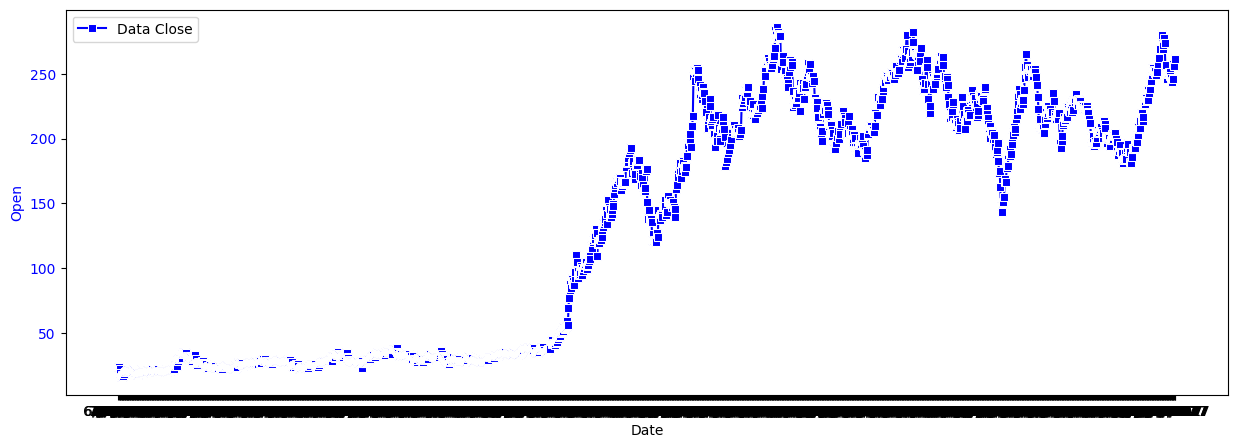

In [23]:
#Allows me to see the evolution of the data Close 
fig, ax1 = plt.subplots(1, figsize = (15, 5))
sns.lineplot(data=df, x=df.index, y='Close', ax = ax1, color='b', label= "Data Close", marker = 's')
plt.ylabel('Open', color='b')
plt.tick_params(axis='y', labelcolor='b')
plt.legend()

# **IV- Handling missing values**


In [25]:
print("Report of the missing values")
missing_values_report(df)

Report of the missing values


,Valeurs Manquantes,Pourcentage
Open,0,0.0
High,0,0.0
Low,0,0.0
Close,0,0.0
Volume,0,0.0
Adj Close,0,0.0


**We can see that no values ​​are missing**

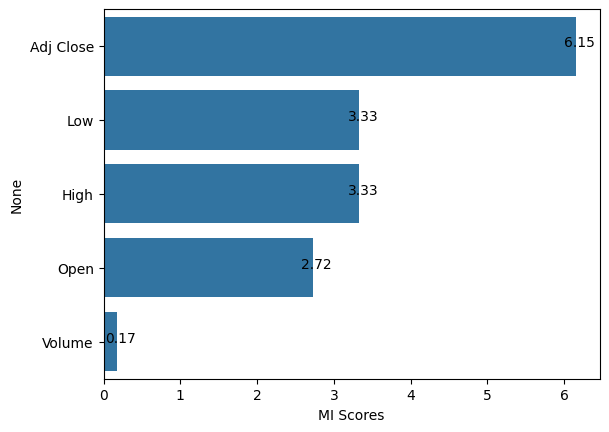

In [27]:
mi_scores = make_mi_scores(df.drop("Close", axis=1), df["Close"]) 
plot_scores(mi_scores, "Mutual Information Scores")

**We can see that the "adj close" variable has a strong communication exchange with the target variable**

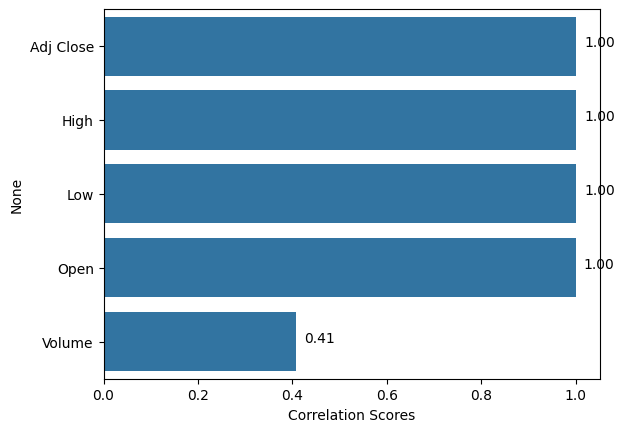

In [29]:
corr_scores = make_corr_scores(df.drop("Close", axis=1), df["Close"]) 
plot_scores(corr_scores, "corr") 

**we can see that all variables except volume have a high correlation rate with the target variable Close**


# **V- Univariate analysis of variables**

In [32]:
resultat_des_calculs = pd.DataFrame(pourcentage(df))
resultat_des_calculs.style.background_gradient()

,nbre_manq,mean,median,var,std,coef_var,skewness,kurtosis,max,min
Open,0,132.441572,156.334999,8894.000000,94.000000,0.712087,-0.027406,-1.755268,287.670013,16.139999
High,0,134.769698,162.370002,9158.000000,96.000000,0.710063,-0.034235,-1.758691,291.420013,16.629999
Low,0,129.996223,153.150002,8622.000000,93.000000,0.714292,-0.021055,-1.752295,280.399994,14.980000
Close,0,132.428658,158.160004,8895.000000,94.000000,0.712181,-0.028001,-1.755399,286.040009,15.800000
Volume,0,4270740.898345,3180700.000000,18455369802797.000000,4295971.000000,1.005908,2.541038,9.782261,37163900.000000,118500.000000
Adj Close,0,132.428658,158.160004,8895.000000,94.000000,0.712181,-0.028001,-1.755399,286.040009,15.800000


- 
We can make the following remarks: 
- 

The Close and Adj Close data have almost the same numerical values.-  

The skewness asymmetry values ​​are very low and therefore will not require any transformation outside of the Volume variable

# **VI- bivariate analysis of variables**


In [35]:
target = df['Close']
features = df.drop(['Close', 'Adj Close'], axis=1)
features1 = df

In [36]:
display(df.corr(method='pearson').style.background_gradient())

,Open,High,Low,Close,Volume,Adj Close
Open,1.000000,0.999623,0.999605,0.999233,0.407515,0.999233
High,0.999623,1.000000,0.999521,0.999691,0.416466,0.999691
Low,0.999605,0.999521,1.000000,0.999656,0.397615,0.999656
Close,0.999233,0.999691,0.999656,1.000000,0.406907,1.000000
Volume,0.407515,0.416466,0.397615,0.406907,1.000000,0.406907
Adj Close,0.999233,0.999691,0.999656,1.000000,0.406907,1.000000


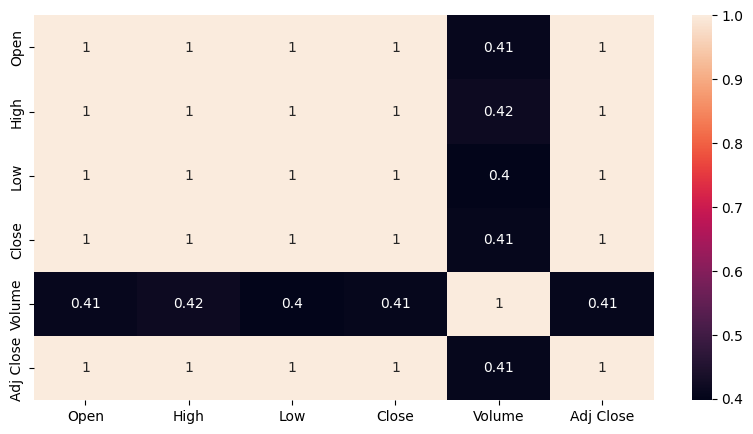

In [37]:
plt.figure(figsize=(10, 5))
sns.heatmap(df.corr(method="pearson"), annot = True)
plt.show()

In [38]:
#I want to select the best features 
label_encoder = LabelEncoder()
train_Y = label_encoder.fit_transform(target)

In [39]:
target_cont = df.Close.apply(lambda x : int(x*100))
print(target_cont)

Date
6/29/2010     2388
6/30/2010     2383
7/1/2010      2195
7/2/2010      1920
7/6/2010      1611
             ...  
3/13/2017    24616
3/14/2017    25800
3/15/2017    25572
3/16/2017    26204
3/17/2017    26150
Name: Close, Length: 1692, dtype: int64


In [40]:
scaled_features = MinMaxScaler().fit_transform(features)
scaled_features

array([[0.01053291, 0.03045963, 0.00964509, 0.50337694],
       [0.03553936, 0.05018378, 0.03134654, 0.46074816],
       [0.03262991, 0.03380764, 0.01993068, 0.21865873],
       ...,
       [0.88704743, 0.88929724, 0.90155229, 0.12682006],
       [0.90693471, 0.90658317, 0.91959914, 0.18846874],
       [0.91282727, 0.90505468, 0.92766189, 0.17161105]])

In [41]:
best_features = SelectKBest(score_func = f_regression, k = 10)
fit = best_features.fit(scaled_features, target_cont)

In [42]:
scores = pd.DataFrame(fit.scores_)
column = pd.DataFrame(features.columns)

In [43]:
features_scores_bestselect = pd.concat([column, scores], axis = 1)
features_scores_bestselect.columns = ['Features', 'Feature_important']

In [44]:
features_scores_bestselect.sort_values(by = 'Feature_important', ascending = False, inplace = True)
features_selectbest = features_scores_bestselect
features_scores_bestselect.style.background_gradient()

,Features,Feature_important
1,High,2732559.049232
2,Low,2455906.776531
0,Open,1100736.284717
3,Volume,335.339072


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


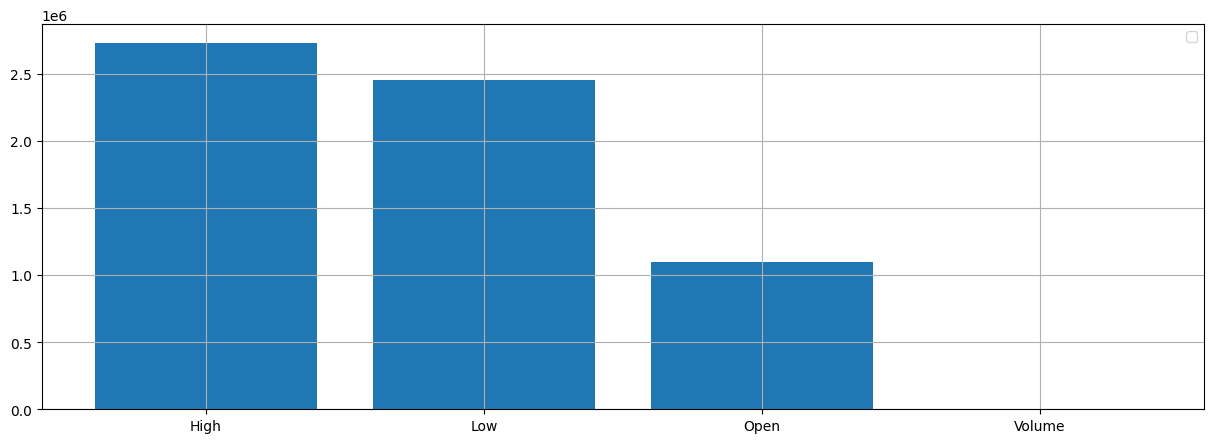

In [45]:
#Visualisons les features importantes 
plt.figure(figsize=(15, 5))
plt.bar(features_scores_bestselect.Features, features_scores_bestselect.Feature_important)
plt.xticks()
plt.grid(True)
plt.legend()
plt.show()

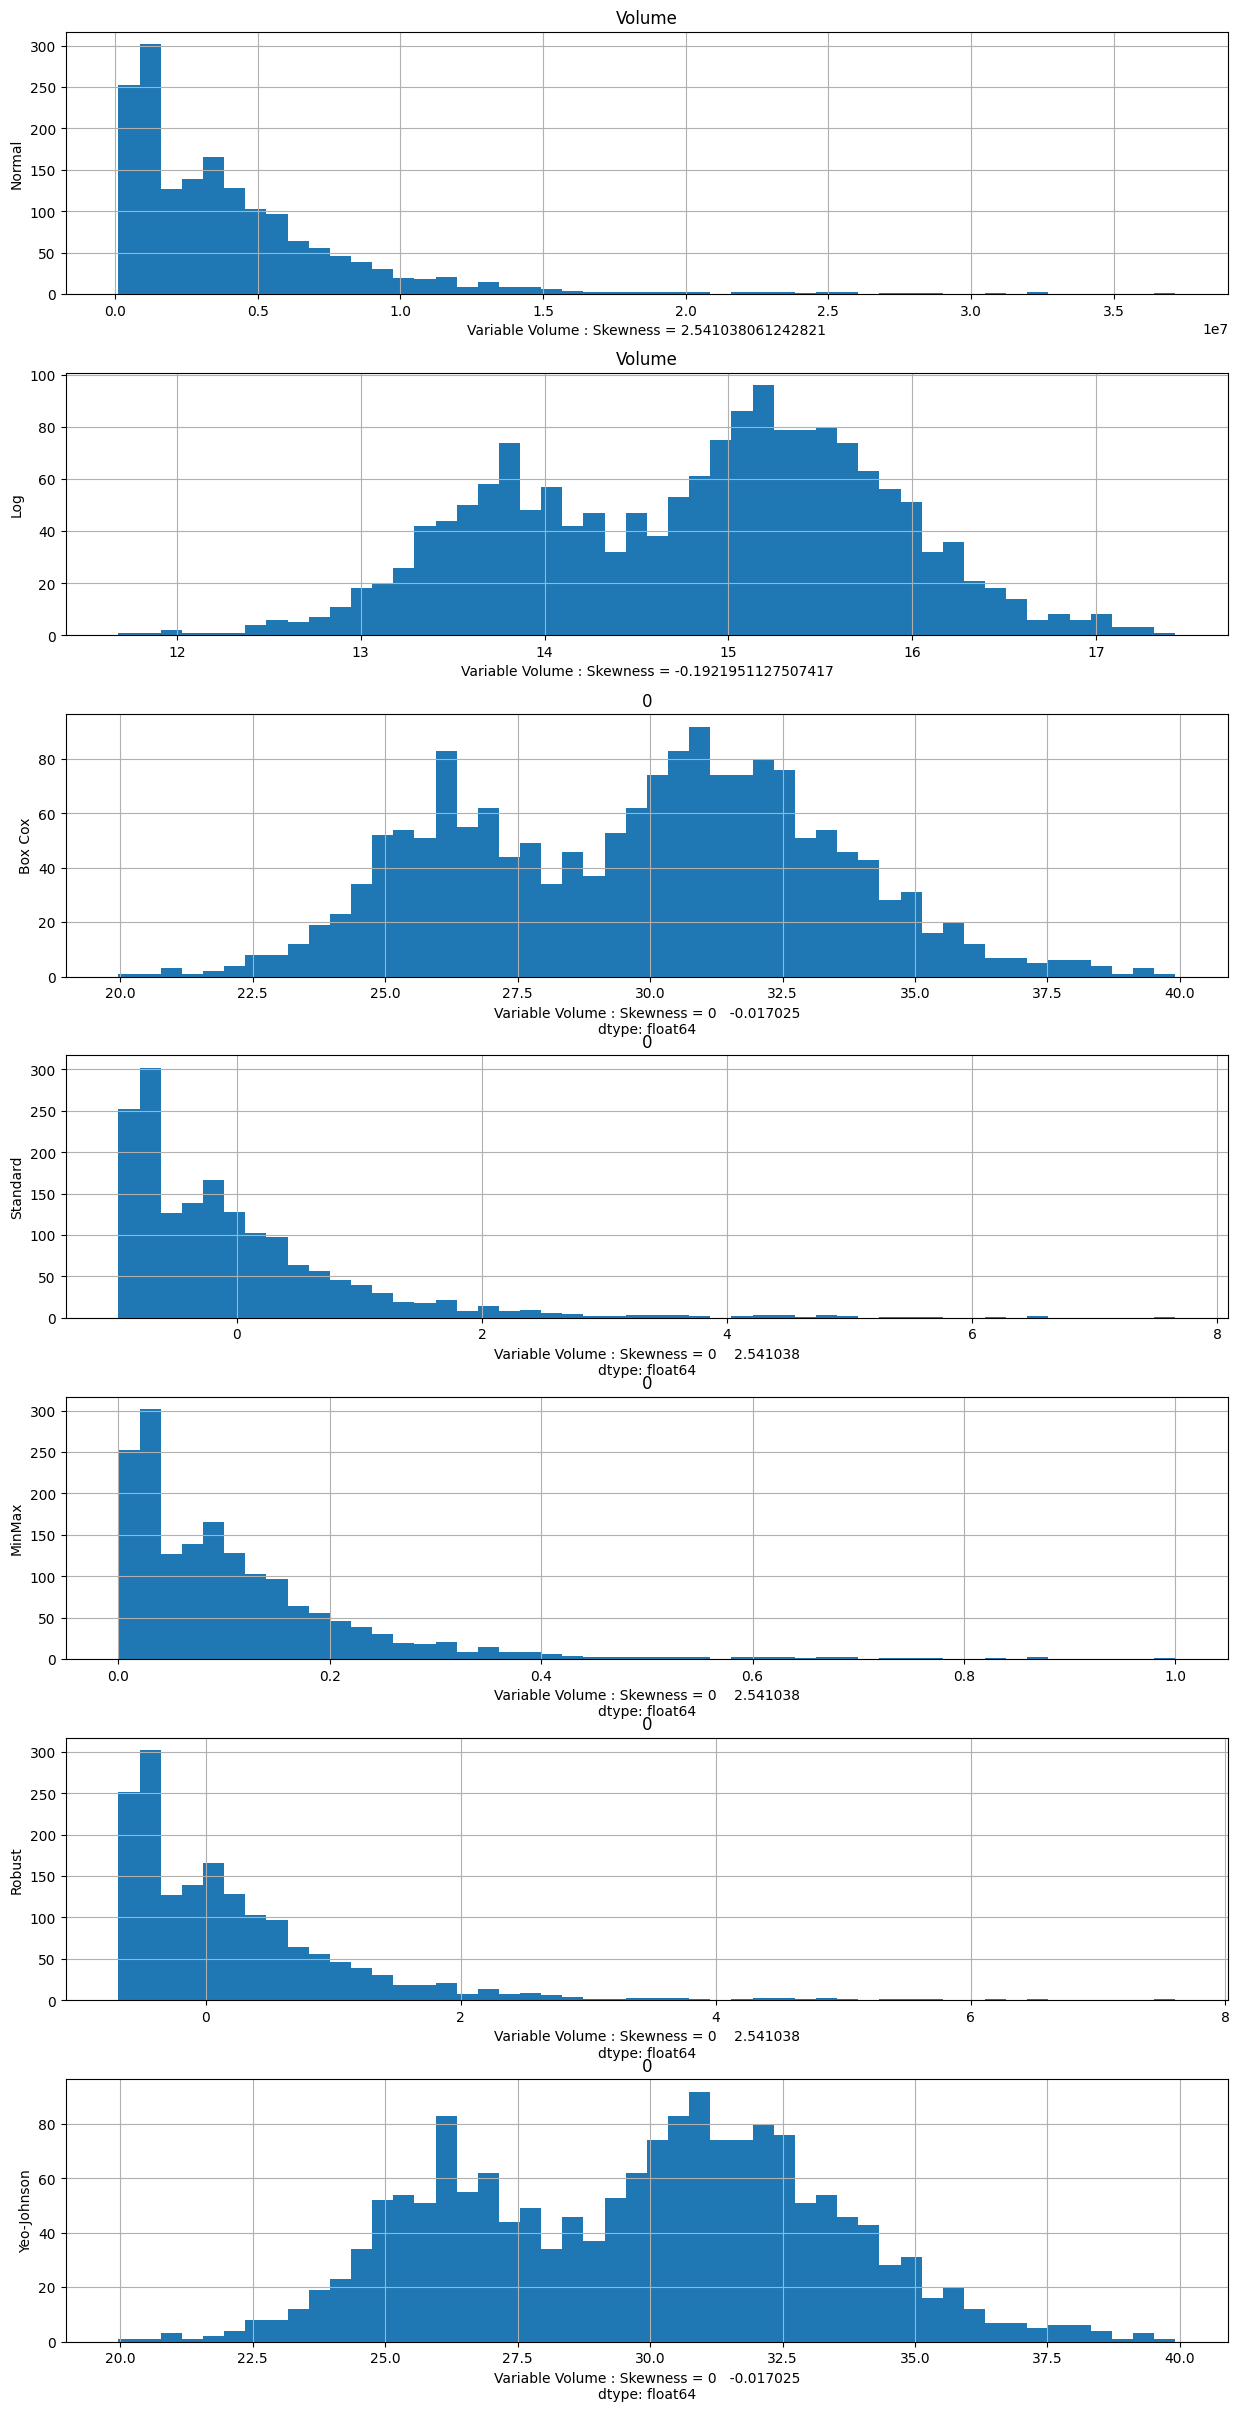

In [46]:
#Me permet de rechercher les meilleurs transformations à travers les figures et le calcul de l'asymétrie skewness
features_to_transform = ['Volume']

for i in features_to_transform:
    
    fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(7, 1, figsize=(15, 30))
    
    pd.DataFrame(features[i]).hist(ax = ax1, bins = 50)
    pd.DataFrame((features[i]+1).transform(np.log)).hist(ax = ax2, bins = 50)
    pd.DataFrame(stats.boxcox(features[i]+1)[0]).hist(ax = ax3, bins = 50)    
    pd.DataFrame(StandardScaler().fit_transform(np.array(features[i]).reshape(-1, 1))).hist(ax = ax4, bins = 50)
    pd.DataFrame(MinMaxScaler().fit_transform(np.array(features[i]).reshape(-1, 1))).hist(ax = ax5, bins = 50)
    pd.DataFrame(RobustScaler().fit_transform(np.array(features[i]).reshape(-1, 1))).hist(ax = ax6, bins = 50)
    pd.DataFrame(stats.yeojohnson(features[i]+1)[0]).hist(ax = ax7, bins = 50)
    
    ax1.set_ylabel('Normal')
    ax1.set_xlabel(f'Variable {i} : Skewness = {features[i].skew()}')
    
    ax2.set_ylabel('Log')
    a = (features[i]+1).transform(np.log)
    ax2.set_xlabel(f'Variable {i} : Skewness = {a.skew()}')
    
    ax3.set_ylabel('Box Cox')
    b = pd.DataFrame(stats.boxcox(features[i]+1)[0])
    ax3.set_xlabel(f'Variable {i} : Skewness = {b.skew()}')
    
    ax4.set_ylabel('Standard')
    c = pd.DataFrame(StandardScaler().fit_transform(np.array(features[i]).reshape(-1,1)))
    ax4.set_xlabel(f'Variable {i} : Skewness = {c.skew()}')
    
    ax5.set_ylabel('MinMax')
    d = pd.DataFrame((MinMaxScaler().fit_transform(np.array(features[i]).reshape(-1,1))))
    ax5.set_xlabel(f'Variable {i} : Skewness = {d.skew()}')

    ax6.set_ylabel('Robust')
    e = pd.DataFrame(RobustScaler().fit_transform(np.array(features[i]).reshape(-1, 1)))
    ax6.set_xlabel(f'Variable {i} : Skewness = {e.skew()}')

    ax7.set_ylabel('Yeo-Johnson')
    f = pd.DataFrame(stats.yeojohnson(features[i]+1)[0])
    ax7.set_xlabel(f'Variable {i} : Skewness = {f.skew()}')

I want to transform volume data to Box-cox transformation

In [48]:
#Before transformation
features.head(3)

,Open,High,Low,Volume
Date,,,,
6/29/2010,19.000000,25.00,17.540001,18766300
6/30/2010,25.790001,30.42,23.299999,17187100
7/1/2010,25.000000,25.92,20.270000,8218800


In [49]:
transform = {
    'Volume' : stats.boxcox(features['Volume']+1)[0], 
}

for i in transform:
    features[i] = transform[i]

In [50]:
#After transformation
features.head(3)

,Open,High,Low,Volume
Date,,,,
6/29/2010,19.000000,25.00,17.540001,37.002965
6/30/2010,25.790001,30.42,23.299999,36.640593
7/1/2010,25.000000,25.92,20.270000,33.703514


# **VII- Preparation standardization and divisions of data**


In [52]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.3, random_state=5)

In [53]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [54]:
x_train.shape, x_test.shape

((1184, 4), (508, 4))

In [55]:
imputer = SimpleImputer(strategy = "median")
x_train = imputer.fit_transform(x_train)
x_test = imputer.fit_transform(x_test)

# **VIII- Implementation of prediction models**


In [57]:
#Me permet de mettre en place le modèle de LinearRegression()
LR_model = LinearRegression()
LR_train_time, LR_predict_time, LR_score_train, LR_score_test, LR_mae, LR_r2, LR_max_error, LR_mse, LR_rmse = make_model(LR_model)

#Me permet de mettre en place le modèle de Ridge()
R_model = Ridge()
R_train_time, R_predict_time, R_score_train, R_score_test, R_mae, R_r2, R_max_error, R_mse, R_rmse = make_model(R_model)

#Me permet de mettre en place le modèle de KNR
KNR_model = KNeighborsRegressor()
KNR_train_time, KNR_predict_time, KNR_score_train, KNR_score_test, KNR_mae, KNR_r2, KNR_max_error, KNR_mse, KNR_rmse = make_model(KNR_model)

#Me permet de mettre en place le modèle de RandomForestRegressor()
RFR_model = RandomForestRegressor()
RFR_train_time, RFR_predict_time, RFR_score_train, RFR_score_test, RFR_mae, RFR_r2, RFR_max_error, RFR_mse, RFR_rmse = make_model(RFR_model)

#Me permet de mettre en place le modèle de SVR()
SVR_model = SVR()
SVR_train_time, SVR_predict_time, SVR_score_train, SVR_score_test, SVR_mae, SVR_r2, SVR_max_error, SVR_mse, SVR_rmse = make_model(SVR_model)

#Me permet de mettre en place le modèle de DecisionTreeRegressor()
DTR_model = DecisionTreeRegressor()
DTR_train_time, DTR_predict_time, DTR_score_train, DTR_score_test, DTR_mae, DTR_r2, DTR_max_error, DTR_mse, DTR_rmse = make_model(DTR_model)

#Me permet de mettre en place le modèle de ElasticNet()
E_model = ElasticNet()
E_train_time, E_predict_time, E_score_train, E_score_test, E_mae, E_r2, E_max_error, E_mse, E_rmse = make_model(E_model)

#Me permet de mettre en place le modèle de lasso()
L_model = Lasso()
L_train_time, L_predict_time, L_score_train, L_score_test, L_mae, L_r2, L_max_error, L_mse, L_rmse = make_model(L_model)

#Me permet de mettre en place le modèle de XGBRegressor()
XGBR_model = XGBRegressor()
XGBR_train_time, XGBR_predict_time, XGBR_score_train, XGBR_score_test, XGBR_mae, XGBR_r2, XGBR_max_error, XGBR_mse, XGBR_rmse = make_model(XGBR_model)

#Me permet de mettre en place le modèle de MLPRegressor()
MLP_model = MLPRegressor()
MLP_train_time, MLP_predict_time, MLP_score_train, MLP_score_test, MLP_mae, MLP_r2, MLP_max_error, MLP_mse, MLP_rmse = make_model(MLP_model)

#Me permet de mettre en place le modèle de GradientBoostingRegressor()
G_model = GradientBoostingRegressor()
G_train_time, G_predict_time, G_score_train, G_score_test, G_mae, G_r2, G_max_error, G_mse, G_rmse = make_model(G_model)

#Me permet de mettre en place le modèle de LGBMRegressor()
LG_model = lgb.LGBMRegressor()
LG_train_time, LG_predict_time, LG_score_train, LG_score_test, LG_mae, LG_r2, LG_max_error, LG_mse, LG_rmse = make_model(LG_model)

#Me permet de mettre en place le modèle de ExtraTreesRegressor()
ETR_model = ExtraTreesRegressor()
ETR_train_time, ETR_predict_time, ETR_score_train, ETR_score_test, ETR_mae, ETR_r2, ETR_max_error, ETR_mse, ETR_rmse = make_model(ETR_model)

#Me permet de mettre en place le modèle de AdaBoostRegressor()
AR_model = AdaBoostRegressor()
AR_train_time, AR_predict_time, AR_score_train, AR_score_test, AR_mae, AR_r2, AR_max_error, AR_mse, AR_rmse = make_model(AR_model)

#Me permet de mettre en place le modèle de CatBoostRegressor()
CBR_model = CatBoostRegressor()
CBR_train_time, CBR_predict_time, CBR_score_train, CBR_score_test, CBR_mae, CBR_r2, CBR_max_error, CBR_mse, CBR_rmse = make_model(CBR_model)

#Me permet de mettre en place le modèle de HistGradientBoostringRegressor()
HR_model = HistGradientBoostingRegressor()
HR_train_time, HR_predict_time, HR_score_train, HR_score_test, HR_mae, HR_r2, HR_max_error, HR_mse, HR_rmse = make_model(HR_model)

Modèle: LinearRegression()
Modèle: Ridge()
Modèle: KNeighborsRegressor()
Modèle: RandomForestRegressor()
Modèle: SVR()
Modèle: DecisionTreeRegressor()
Modèle: ElasticNet()
Modèle: Lasso()
Modèle: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
Modèle: MLPRegressor()
Modèle: GradientBoostingRegressor(

# **IX- Comparison of models**

In [59]:
compare_model = pd.DataFrame({
    "Model": ["Ridge()", "KNeighborsRegressor()", "LinearRegression()", "RandomForestRegressor()", "SVR()", "DecisionTreeRegressor()", "ElasticNet", "Lasso()", "XGBRegressor()", "MLPRegressor()", "GradientBoostringRegressor()", "LGBMRegressor()", "ExtraTreesRegressor()", "AdaBoostRegressor()", "CatBoostRegressor()", "HistGradientBoostingRegressor()"],
    "Train Time": [R_train_time, KNR_train_time, LR_train_time, RFR_train_time, SVR_train_time, DTR_train_time, E_train_time, L_train_time, XGBR_train_time, MLP_train_time, G_train_time, LG_train_time, ETR_train_time, AR_train_time, CBR_train_time, HR_train_time], 
    "Predict Time": [R_predict_time, KNR_predict_time, LR_predict_time, RFR_predict_time, SVR_predict_time, DTR_predict_time, E_predict_time, L_predict_time, XGBR_predict_time, MLP_predict_time, G_predict_time, LG_predict_time, ETR_predict_time, AR_predict_time, CBR_predict_time, HR_predict_time], 
    "Train Score": [R_score_train, KNR_score_train, LR_score_train, RFR_score_train, SVR_score_train, DTR_score_train, E_score_train, L_score_train, XGBR_score_train, MLP_score_train, G_score_train, LG_score_train, ETR_score_train, AR_score_train, CBR_score_train, HR_score_train], 
    "Test Score": [R_score_test, KNR_score_test, LR_score_test, RFR_score_test, SVR_score_test, DTR_score_test, E_score_test, L_score_test, XGBR_score_test, MLP_score_test, G_score_test, LG_score_test, ETR_score_test, AR_score_test, CBR_score_test, HR_score_test],
    "MAE": [R_mae, KNR_mae, LR_mae, RFR_mae, SVR_mae, DTR_mae, E_mae, L_mae, XGBR_mae, MLP_mae, G_mae, LG_mae, ETR_mae, AR_mae, CBR_mae, HR_mae],
    "R2": [R_r2, KNR_r2, LR_r2, RFR_r2, SVR_r2, DTR_r2, E_r2, L_r2, XGBR_r2, MLP_r2, G_r2, LG_r2, ETR_r2, AR_r2, CBR_r2, HR_r2],
    "Max_Error": [R_max_error, KNR_max_error, LR_max_error, RFR_max_error, SVR_max_error, DTR_max_error, E_max_error, L_max_error, XGBR_max_error, MLP_max_error, G_max_error, LG_max_error, ETR_max_error, AR_max_error, CBR_max_error, HR_max_error],
    "MSE": [R_mse, KNR_mse, LR_mse, RFR_mse, SVR_mse, DTR_mse, E_mse, L_mse, XGBR_mse, MLP_mse, G_mse, LG_mse, ETR_mse, AR_mse, CBR_mse, HR_mse], 
    "RMSE": [R_rmse, KNR_rmse, LR_rmse, RFR_rmse, SVR_rmse, DTR_rmse, E_rmse, L_rmse, XGBR_rmse, MLP_rmse, G_rmse, LG_rmse, ETR_rmse, AR_rmse, CBR_rmse, HR_rmse]
})

compare_model.style.background_gradient(subset = ['Train Score', 'Test Score', 'MAE', 'R2', 'Max_Error', 'MSE','RMSE'], cmap = 'RdPu')

,Model,Train Time,Predict Time,Train Score,Test Score,MAE,R2,Max_Error,MSE,RMSE
0,Ridge(),0.080728,0.000000,0.999547,0.999484,1.376466,0.999484,9.405272,4.581481,2.140439
1,KNeighborsRegressor(),0.001995,0.001994,0.999254,0.998549,2.267905,0.998549,20.448013,12.892002,3.590543
2,LinearRegression(),0.521618,0.000000,0.999739,0.999775,0.949844,0.999775,6.930625,1.996300,1.412905
3,RandomForestRegressor(),0.961893,0.043017,0.999934,0.999473,1.375323,0.999473,12.288996,4.678882,2.163072
4,SVR(),0.118714,0.093749,0.986795,0.985948,6.802314,0.985948,53.698800,124.847954,11.173538
5,DecisionTreeRegressor(),0.009974,0.001033,1.000000,0.999323,1.609468,0.999323,14.000000,6.018828,2.453330
6,ElasticNet,0.084772,0.000000,0.976152,0.975558,13.279829,0.975558,34.855511,217.162425,14.736432
7,Lasso(),0.005982,0.000459,0.999207,0.998968,2.186228,0.998968,15.371756,9.165760,3.027501
8,XGBRegressor(),0.569327,0.003990,0.999983,0.999205,1.571490,0.999205,22.548924,7.066950,2.658374
9,MLPRegressor(),1.336004,0.023936,0.961398,0.957626,14.051758,0.957626,85.481318,376.487619,19.403289


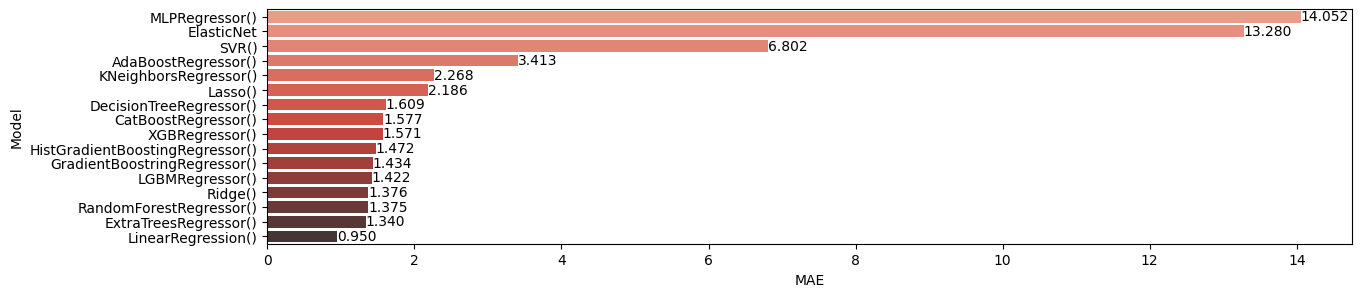

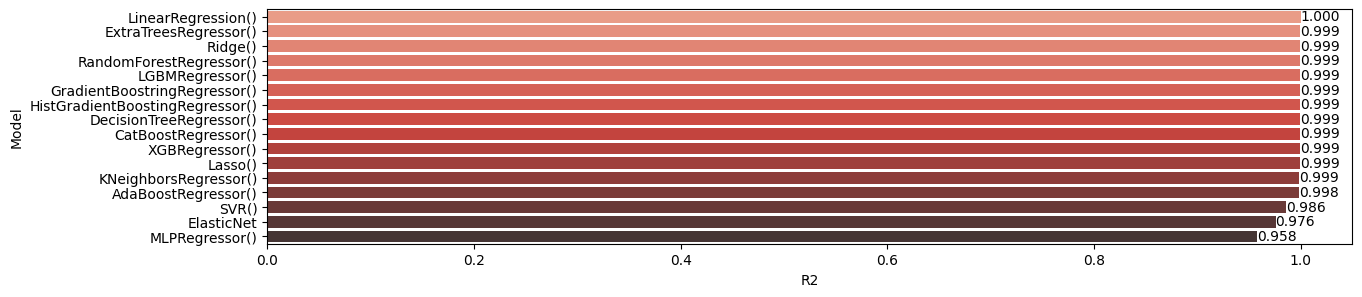

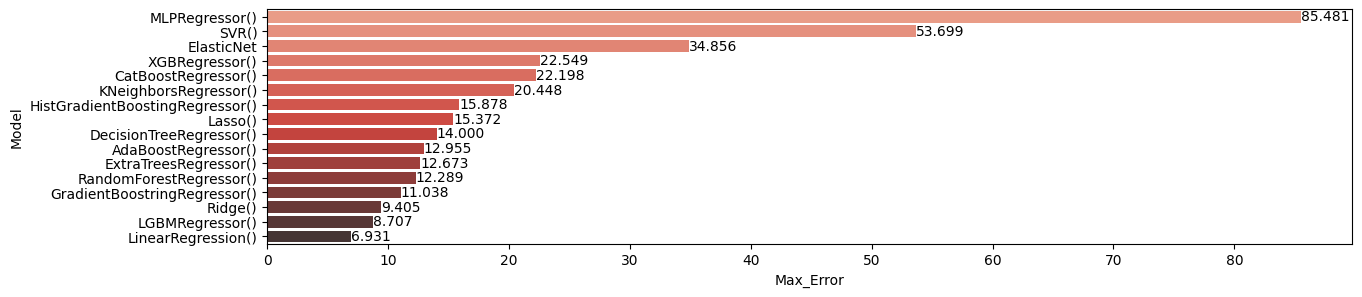

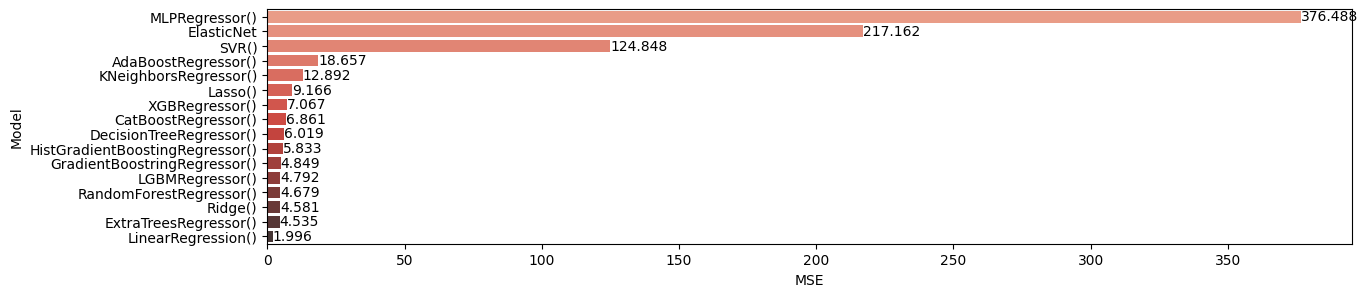

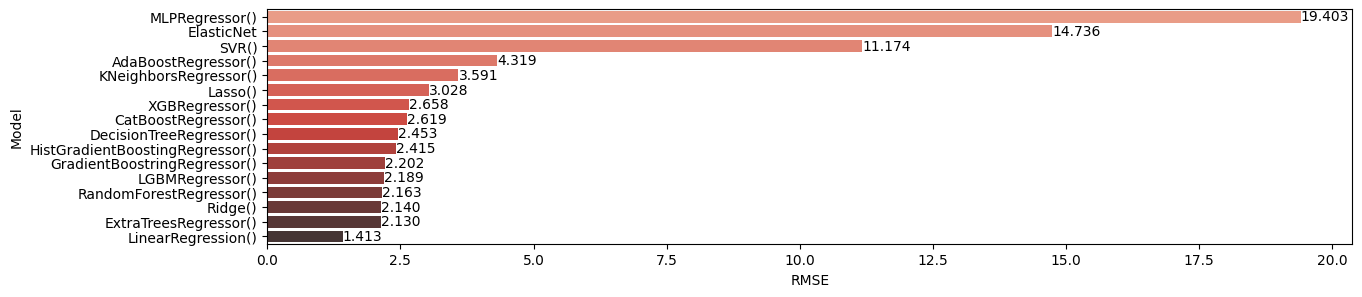

In [60]:
#Me permet de visualiser les différentes métriques
def labels(ax):
    for p in ax.patches:
        width = p.get_width()                     
        ax.text(width, p.get_y() + p.get_height() / 2, '{:1.3f}'.format(width), ha = 'left', va = 'center')                       

#Me permet de visualiser la MAE
plt.figure(figsize=(14,14))
plt.subplot(411)
compare_model = compare_model.sort_values(by="MAE", ascending=False)
ax=sns.barplot(x="MAE", y="Model", data=compare_model, palette="Reds_d")
labels(ax)

#Me permet de visualiser le R²
plt.figure(figsize=(14,14))
plt.subplot(412)
compare_model = compare_model.sort_values(by="R2", ascending=False)
ax=sns.barplot(x="R2", y="Model", data=compare_model, palette="Reds_d")
labels(ax)

#Me permet de visualiser le Max_Error
plt.figure(figsize=(14,14))
plt.subplot(411)
compare_model = compare_model.sort_values(by="Max_Error", ascending=False)
ax=sns.barplot(x="Max_Error", y="Model", data=compare_model, palette="Reds_d")
labels(ax)

#Me permet de visualiser la MSE
plt.figure(figsize=(14,14))
plt.subplot(411)
compare_model = compare_model.sort_values(by="MSE", ascending=False)
ax=sns.barplot(x="MSE", y="Model", data=compare_model, palette="Reds_d")
labels(ax)

#Me permet de visualiser la RMSE
plt.figure(figsize=(14,14))
plt.subplot(411)
compare_model = compare_model.sort_values(by="RMSE", ascending=False)
ax=sns.barplot(x="RMSE", y="Model", data=compare_model, palette="Reds_d")
labels(ax)

plt.show()

In [61]:
#Definition of pipeline 
lr_model = LinearRegression()
lr_model

LinearRegression()

In [62]:
lr_model.fit(x_train, y_train)

LinearRegression()

In [63]:
parameters = {
    'fit_intercept': [True, False], 
    'copy_X': [True, False], 
    'n_jobs': np.arange(1, 5),
    'positive': [True, False]
}

In [64]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 5)
grid = GridSearchCV(lr_model, parameters, cv = kf, verbose = 1)

In [65]:
grid.fit(x_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=5, shuffle=True),
             estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'n_jobs': array([1, 2, 3, 4]),
                         'positive': [True, False]},
             verbose=1)

In [66]:
model = grid.fit(x_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


In [67]:
print("best score : ", model.best_score_)
print("best parameters : ", model.best_params_)

best score :  0.999727972159991
best parameters :  {'copy_X': True, 'fit_intercept': True, 'n_jobs': 1, 'positive': False}


In [68]:
y_pred = model.predict(x_test)

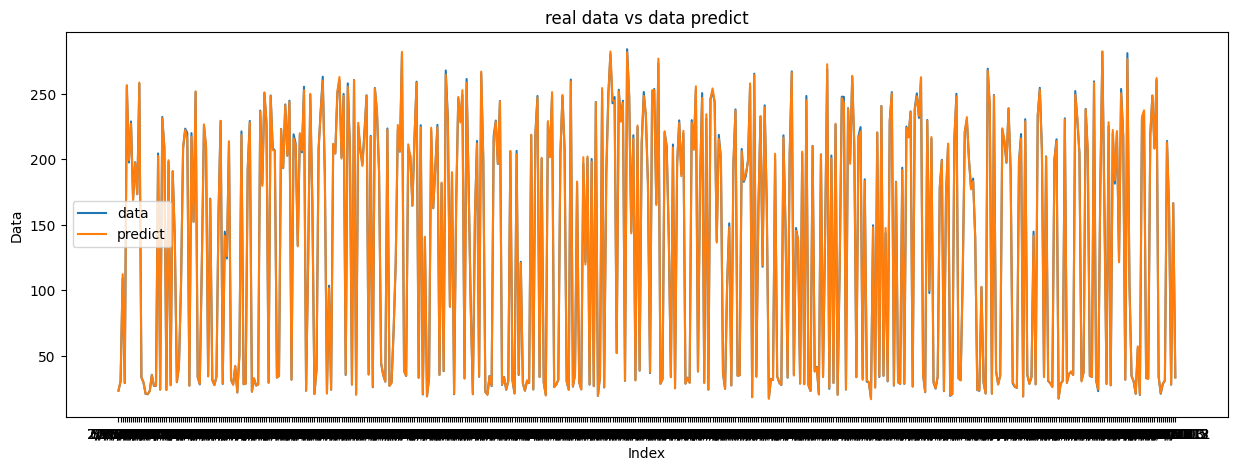

In [69]:
plt.figure(figsize = (15, 5))
plt.plot(y_test, label='data')
plt.plot(y_pred, label='predict')
plt.xlabel('Index')
plt.ylabel('Data')
plt.title('real data vs data predict')
plt.legend()
plt.show()